# Mini-Project 1 : Image Classification and Regression


The goal of this project is to learn how to implement simple image classification and regression
in Keras. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf 
import keras
from keras.utils import np_utils

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

Using TensorFlow backend.


## Preliminary 

We generate a training set of images of simple geometric shapes (rectangle, disk, triangle)
centered in the images by calling the function __generate_dataset_classification__. This function generates a dataset of images containing one of the tree diffirent shapes.


In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata


In [3]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


In [4]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [5]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

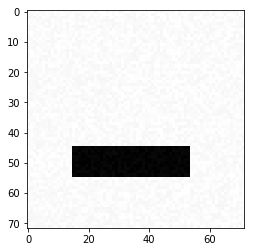

In [6]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

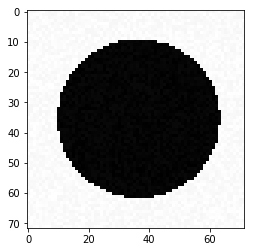

In [7]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

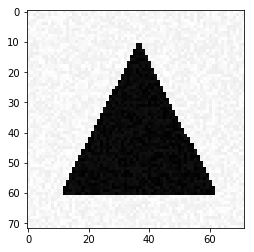

In [8]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [9]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [10]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]


In [11]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [12]:
import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()
    
    
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


# Simple Classification

We start generating a training set of images of simple geometric shapes (rectangle, disk, triangle) centered in the images. We build and train a linear classifier in Keras to classify an image into one of the three possible categories (i.e. rectangle, disk, triangle). The classes labels are $0$ for rectangle, $1$ for the disk and $2$ for the traingle. In this first part the shapes are not allowed to move within the images and change dimensions.

In [13]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We will first train our model using the stochastic gradient descent optimizer, then
the Adam optimizer.

### Training The model using stochastic gradient optimizer

When using stochastic gradient the value of the learning rate is crusual. We can see a big difference in the performence using $lr=0.01$ and $lr=0.001$ 

In [14]:
# We define our linear model as a neural network containing one layer
from keras import optimizers, Sequential
from keras.layers import Dense

model = Sequential([
    Dense(3, activation=tf.nn.softmax)
])

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, np_utils.to_categorical(Y_train), epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 0s 2ms/step - loss: 0.9761 - acc: 0.5567
Epoch 2/10
300/300 [==============================] - 0s 126us/step - loss: 0.7094 - acc: 0.6833
Epoch 3/10
300/300 [==============================] - 0s 163us/step - loss: 0.5107 - acc: 0.7800
Epoch 4/10
300/300 [==============================] - 0s 146us/step - loss: 0.4240 - acc: 0.8033
Epoch 5/10
300/300 [==============================] - 0s 120us/step - loss: 0.4177 - acc: 0.8000
Epoch 6/10
300/300 [==============================] - 0s 153us/step - loss: 0.3487 - acc: 0.8767
Epoch 7/10
300/300 [==============================] - 0s 146us/step - loss: 0.2992 - acc: 0.8900
Epoch 8/10
300/300 [==============================] - 0s 146us/step - loss: 0.2528 - acc: 0.9567
Epoch 9/10
300/300 [==============================] - 0s 166us/step - loss: 0.2600 - acc: 0.8900
Epoch 10/10
300/300 [==============================] - 0s 146us/step - loss: 0.2237 - acc: 0.9367


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


Let's check the prediction of our model on a test image

In [16]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

We can evaluate the linear model performence on a test data set, that we generate using the function __generate_test_set_classification__

In [17]:
[X_test, Y_test] = generate_test_set_classification()
model.evaluate(X_test, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 316us/step


[2.010622495015462, 0.3299999996026357]

### Training The model using stochastic gradient optimizer

In [18]:
# We define our linear model as a neural network containing one layer
from keras import optimizers, Sequential
from keras.layers import Dense

model = Sequential([
    Dense(3, activation=tf.nn.softmax)
])

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, np_utils.to_categorical(Y_train), epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 0s 922us/step - loss: 1.0966 - acc: 0.4567
Epoch 2/10
300/300 [==============================] - 0s 136us/step - loss: 0.8189 - acc: 0.6100
Epoch 3/10
300/300 [==============================] - 0s 130us/step - loss: 0.5821 - acc: 0.7767
Epoch 4/10
300/300 [==============================] - 0s 130us/step - loss: 0.4250 - acc: 0.8267
Epoch 5/10
300/300 [==============================] - 0s 133us/step - loss: 0.3534 - acc: 0.8900
Epoch 6/10
300/300 [==============================] - 0s 130us/step - loss: 0.3808 - acc: 0.8400
Epoch 7/10
300/300 [==============================] - 0s 136us/step - loss: 0.2825 - acc: 0.8900
Epoch 8/10
300/300 [==============================] - 0s 150us/step - loss: 0.2635 - acc: 0.9133
Epoch 9/10
300/300 [==============================] - 0s 153us/step - loss: 0.2359 - acc: 0.9333
Epoch 10/10
300/300 [==============================] - 0s 183us/step - loss: 0.2176 - acc: 0.9600


Let's check the prediction of our model on a test image

In [19]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1.0000000e+00, 2.8984789e-30, 0.0000000e+00]], dtype=float32)

We can evaluate the linear model performence on a test data set, that we generate using the function __generate_test_set_classification__

In [20]:
[X_test, Y_test] = generate_test_set_classification()
model.evaluate(X_test, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 356us/step


[2.068395986557007, 0.33666666626930236]

__Conclusion :__ The stochastic gradient and adam optimizer gives approximatly the same results, when the learning rate used in SGD is well-tuned. Generally it is better to use Adam optimizer, because we don't need to fine tune the learning rate.

### Visualization of the Solution

We would like to visualize the weights of the linear classifier. We can do so by using the output of the finction __model.get_weights()__

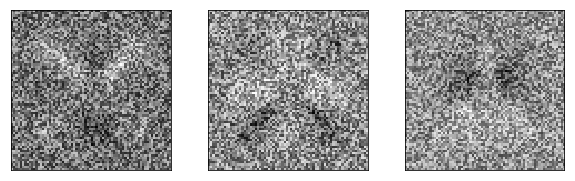

In [21]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(model.get_weights()[0][:,i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.binary)

# A More Difficult Classification Problem
Now, the shapes are allowed to move within the images and change dimensions.

In [22]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We retrain our linear classifier on this new training set : 

In [23]:
model = keras.Sequential([
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, np_utils.to_categorical(Y_train), epochs=10)

Epoch 1/10
300/300 [==============================] - 0s 1ms/step - loss: 2.4075 - acc: 0.2867
Epoch 2/10
300/300 [==============================] - 0s 106us/step - loss: 1.5237 - acc: 0.3400
Epoch 3/10
300/300 [==============================] - 0s 133us/step - loss: 1.0799 - acc: 0.4833
Epoch 4/10
300/300 [==============================] - 0s 140us/step - loss: 1.0146 - acc: 0.5067
Epoch 5/10
300/300 [==============================] - 0s 120us/step - loss: 1.0558 - acc: 0.4800
Epoch 6/10
300/300 [==============================] - 0s 133us/step - loss: 0.9503 - acc: 0.5233
Epoch 7/10
300/300 [==============================] - 0s 140us/step - loss: 0.9314 - acc: 0.5100
Epoch 8/10
300/300 [==============================] - 0s 120us/step - loss: 0.8999 - acc: 0.5633
Epoch 9/10
300/300 [==============================] - 0s 163us/step - loss: 1.0134 - acc: 0.5567
Epoch 10/10
300/300 [==============================] - 0s 166us/step - loss: 0.9379 - acc: 0.5733


We evaluate our classifier on a generated data set :

In [24]:
[X_test, Y_test] = generate_test_set_classification()
model.evaluate(X_test, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 372us/step


[1.0450196321805318, 0.57]

In order the improve the model performence, we train a convolutional (not-to-)deep network on this new train dataset: 

We start first by reshapping the train set and the test set, and we transform the labels with a one-hot encoding for the train set( it is already done for the test set labels)

In [25]:
X_train = X_train.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)
X_test = X_test.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)

from keras.utils import to_categorical
#one-hot encode target column
Y_train = to_categorical(Y_train)

Our architechture is the one proposed : 1 convolutional layer with 16 5×5 filters, 1 pooling layer, and
one fully connected layer.

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(16, kernel_size=5, activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 55491     
Total params: 55,907
Trainable params: 55,907
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10, batch_size= 32)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 1.2748 - acc: 0.3833
Epoch 2/10
300/300 [==============================] - 1s 2ms/step - loss: 0.9701 - acc: 0.6267
Epoch 3/10
300/300 [==============================] - 1s 2ms/step - loss: 0.8311 - acc: 0.7033
Epoch 4/10
300/300 [==============================] - 1s 2ms/step - loss: 0.7350 - acc: 0.7900
Epoch 5/10
300/300 [==============================] - 1s 2ms/step - loss: 0.6510 - acc: 0.8033
Epoch 6/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5794 - acc: 0.8167
Epoch 7/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5091 - acc: 0.8667
Epoch 8/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4920 - acc: 0.8233
Epoch 9/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4531 - acc: 0.8567
Epoch 10/10
300/300 [==============================] - 1s 2ms/step - loss: 0.4162 - acc: 0.8800


In [29]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 1ms/step


[0.7923647856712341, 0.6299999992052714]

# A Regression Problem
The task now is to predict the image locations of the vertices of a triangle, given an image of this
triangle.

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


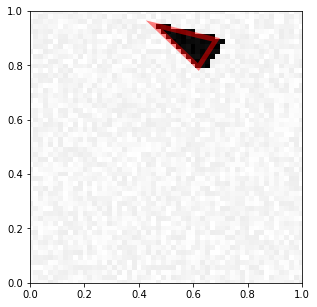

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [49]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
visualize_prediction(X_train[6], Y_train[6])

[X_test, Y_test] = generate_test_set_regression()

X_train = X_train.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)
X_test = X_test.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)

In [50]:
model = Sequential()
#add model layers
model.add(Conv2D(16, kernel_size=5, activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(6, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())

# Fit the model
model.fit(X_train, Y_train, batch_size=16, epochs=10)

Epoch 1/10
300/300 [==============================] - 2s 5ms/step - loss: 0.5661
Epoch 2/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0890
Epoch 3/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0672
Epoch 4/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0590
Epoch 5/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0547
Epoch 6/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0498
Epoch 7/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0452
Epoch 8/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0416
Epoch 9/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0393
Epoch 10/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0375


In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               1849700   
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 606       
Total params: 1,850,722
Trainable params: 1,850,722
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 2ms/step


0.06899140387773514

Let's visualize the prediction of our model, on the test set

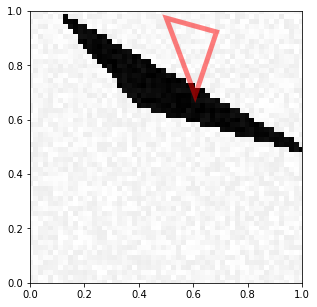

In [53]:
Y_pred = model.predict(X_test)
visualize_prediction(X_test[6], Y_pred[6])

# Image Denoising

We start writting a function generating two images, where one image has noise with random amplitude, and the second image has the same content but without the noise.

In [35]:
def generate_a_drawing_with_noise(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_with_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata, imdata_with_noise

In [36]:
def generate_a_triangle_with_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata, imdata_with_noise = generate_a_drawing_with_noise(figsize, U, V, noise)
    return [imdata, imdata_with_noise, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_a_rectangle_with_noise(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_with_noise(figsize, U, V, noise)

def generate_a_disk_with_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_with_noise(figsize, U, V, noise)

In [37]:
def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_with_noise = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise = np.random.randint(255/2)
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], X_with_noise[i] = generate_a_rectangle_with_noise(noise, free_location)
        elif category == 1: 
            X[i], X_with_noise[i] = generate_a_disk_with_noise(noise, free_location)
        else:
            [X[i], X_with_noise[i], V] = generate_a_triangle_with_noise(noise, free_location)
        X[i] = (X[i] + noise) / (255 + 2 * noise)
        X_with_noise[i] = (X_with_noise[i] + noise) / (255 + 2 * noise)
    return [X, X_with_noise]

In [38]:
[X_train, X_train_noise] = generate_dataset_denoising(300, free_location=True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


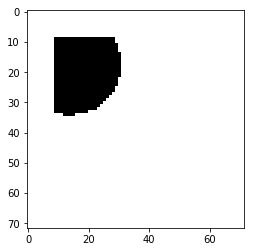

In [39]:
plt.imshow(X_train[0].reshape((IMAGE_SIZE,IMAGE_SIZE)),cmap='gray')

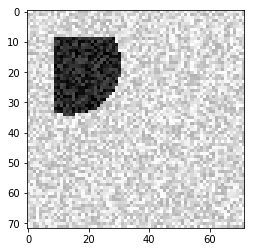

In [40]:
plt.imshow(X_train_noise[0].reshape((IMAGE_SIZE,IMAGE_SIZE)),cmap='gray')

## Defining and Traing the model

To Denoise image we well a hourglass network. And we train our network to predict a noise-free image given a noisy
image as input.

In [41]:
X_train = X_train.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)
X_train_noise = X_train_noise.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)

In [42]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model

input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = Conv2D(IMAGE_SIZE, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(IMAGE_SIZE, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(IMAGE_SIZE, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(IMAGE_SIZE, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [43]:
from keras.optimizers import Adam

model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 72)        720       
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 72)        288       
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 72)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 72)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 72)        46728     
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 36, 72)        288       
__________

In [45]:
history = model.fit(X_train_noise, X_train,
                    batch_size=16,
                    epochs=10)

Epoch 1/10
300/300 [==============================] - 31s 103ms/step - loss: 0.0773
Epoch 2/10
300/300 [==============================] - 39s 131ms/step - loss: 0.0657
Epoch 3/10
300/300 [==============================] - 36s 119ms/step - loss: 0.0619
Epoch 4/10
300/300 [==============================] - 30s 101ms/step - loss: 0.0592
Epoch 5/10
300/300 [==============================] - 32s 107ms/step - loss: 0.0564
Epoch 6/10
300/300 [==============================] - 42s 140ms/step - loss: 0.0540
Epoch 7/10
300/300 [==============================] - 38s 128ms/step - loss: 0.0517
Epoch 8/10
300/300 [==============================] - 36s 121ms/step - loss: 0.0496
Epoch 9/10
300/300 [==============================] - 37s 122ms/step - loss: 0.0474
Epoch 10/10
300/300 [==============================] - 37s 125ms/step - loss: 0.0452


In [46]:
X_pred = model.predict(X_train_noise)


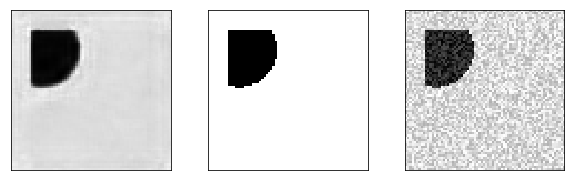

In [47]:
plt.figure(figsize=(10,10))

plt.subplot(3,3,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(X_pred[0,:,:,0], cmap='gray')

plt.subplot(3,3,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(X_train[0,:,:,0], cmap='gray')

plt.subplot(3,3,3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(X_train_noise[0,:,:,0], cmap='gray')